In [185]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.exceptions import QiskitError

class AmplitudeEmbedding:
    
    def __init__(self, num_qubits: int):
        """
        Class that generates a general feature map that can map any statevector given input in the form of angles.
        """
        
        r"""
        Args:

            num_qubits: Integer that describes the number of qubits that amplitude embedding is being applied on.
            Note: To map a statevector with 8 elements only requires 3 qubits due to the log base 2 of 8 = 3.
            
        Computing the angles can be done with help from [2]. DO NOT TRY TO CREATE A STATEVECTOR IF YOU DO NOT HAVE AN
        ADEQUATE NUMBER OF ANGLE PARAMETERS. This error is outside of the class.
            
        **References:**
        [1] https://docs.pennylane.ai/en/stable/introduction/templates.html

        [2] https://github.com/Qiskit/qiskit/blob/stable/0.20/qiskit/circuit/library/data_preparation/state_preparation.py
        """
    
        if num_qubits <= 0:
            raise QiskitError("num_qubits must be a positive integer.")
            
        self.num_qubits = num_qubits
        self.target_sequences = self.generate_target_sequences()
        num_crx_gates = sum(len(seq) for seq in self.target_sequences)
        self.num_gates = sum(2**i for i in range(1, num_qubits + 1)) * 2 + num_crx_gates  
        self.parameters = ParameterVector('x', length=self.num_gates)
        
    @staticmethod
    def calculate_num_qubits(vector_length):
        num_qubits = 0
        total_gates = 0
        
        while total_gates < vector_length:
            num_qubits += 1
            total_gates += 2 ** num_qubits
        
        if total_gates == vector_length:
            return num_qubits
        else:
            raise QiskitError("The vector length does not correspond to any valid number of qubits.")

    @staticmethod
    def diagnostic(vector):
        vector_length = len(vector)
        num_qubits = AmplitudeEmbedding.calculate_num_qubits(vector_length)
        
        array = [(2 ** i) // 2 for i in range(num_qubits, 0, -1)]
        rz_indices = []
        ry_indices = []
        crx_indices = []
        rz_counts = []

        param_index = 0

        for qubit, num_gates in enumerate(array):
            rz_counts.append(num_gates)
            if qubit < len(AmplitudeEmbedding.generate_target_sequences_static(num_qubits)):
                target_sequence = AmplitudeEmbedding.generate_target_sequences_static(num_qubits)[qubit]
            else:
                target_sequence = [1] * (num_gates - 1)

            for i in range(num_gates):
                rz_indices.append(param_index)  
                param_index += 1
                if i < num_gates - 1:
                    crx_indices.append(param_index)  
                    param_index += 1
                    
            for i in range(num_gates):
                ry_indices.append(param_index)  
                param_index += 1
                if i < num_gates - 1:
                    crx_indices.append(param_index)  
                    param_index += 1

        return rz_indices, ry_indices, crx_indices, rz_counts, num_qubits
    
    @staticmethod
    def generate_target_sequences_static(num_qubits):
        def generate_sequence(n):
            if n == 2:
                return [1, 1]
            elif n == 3:
                return [1, 2, 1]
            else:
                previous_sequence = generate_sequence(n - 1)
                return previous_sequence + [n - 1] + previous_sequence

        all_sequences = []
        for n in range(num_qubits, 1, -1):
            all_sequences.append(generate_sequence(n))
        return all_sequences

    def generate_target_sequences(self):
        return AmplitudeEmbedding.generate_target_sequences_static(self.num_qubits)

    def create_quantum_circuit(self):
        array = [(2 ** i) // 2 for i in range(self.num_qubits, 0, -1)]

        qc = QuantumCircuit(self.num_qubits)

        param_index = 0  

        for qubit, num_gates in enumerate(array):
            if qubit < len(self.target_sequences):
                target_sequence = self.target_sequences[qubit]
            else:
                target_sequence = [1] * (num_gates - 1)

            for i in range(num_gates):
                qc.rz(-self.parameters[param_index], qubit)
                param_index += 1
                if i < num_gates - 1:
                    target_qubit = (qubit + target_sequence[i % len(target_sequence)]) % self.num_qubits
                    qc.crx(-self.parameters[param_index], target_qubit, qubit)
                    param_index += 1
                    
            for i in range(num_gates):
                qc.ry(-self.parameters[param_index], qubit)
                param_index += 1
                if i < num_gates - 1:
                    target_qubit = (qubit + target_sequence[i % len(target_sequence)]) % self.num_qubits
                    qc.cx(target_qubit, qubit)
                    param_index += 1

        return qc.inverse()

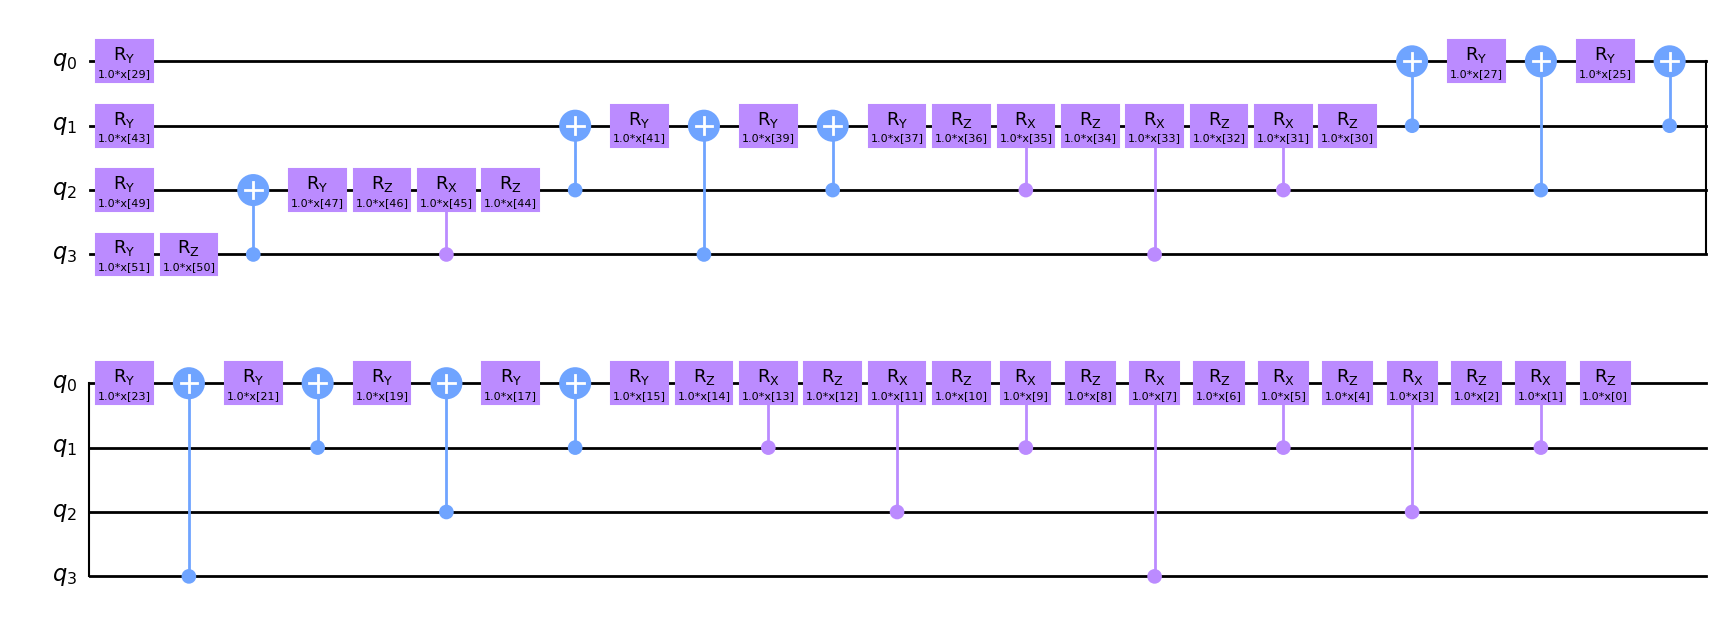

In [189]:
num_qubits = 4
embedding = AmplitudeEmbedding(num_qubits)
qc = embedding.create_quantum_circuit()
qc.draw(output='mpl')

In [192]:
vector = [i for i in range(30)]
rz, ry, crx, num_rz, num_qubits = AmplitudeEmbedding.diagnostic(vector)

In [193]:
rz, ry, crx, num_rz, num_qubits

([0, 2, 4, 6, 8, 10, 12, 14, 30, 32, 34, 36, 44, 46, 50],
 [15, 17, 19, 21, 23, 25, 27, 29, 37, 39, 41, 43, 47, 49, 51],
 [1,
  3,
  5,
  7,
  9,
  11,
  13,
  16,
  18,
  20,
  22,
  24,
  26,
  28,
  31,
  33,
  35,
  38,
  40,
  42,
  45,
  48],
 [8, 4, 2, 1],
 4)